# __Predicting NTL using DTL__

CNN Model for predicting nighttime lights using daytime images.

## Parameters

In [61]:
PARAM_NAME_RGB = "Nbands3_nNtlBins3_minNTLbinCount100"
#PARAM_NAME = "Nbands3_nNtlBins3_minNTLbinCount100"
YEAR = 2014
PARAM_NAME_1 = "Band1_nNtlBins3_minNTLbinCount1861"
PARAM_NAME_5 = "Band5_nNtlBins3_minNTLbinCount1861"
PARAM_NAME_6 = "Band6_nNtlBins3_minNTLbinCount1861"
PARAM_NAME_7 = "Band7_nNtlBins3_minNTLbinCount1861"

In [62]:
!pip install -U efficientnet
!pip install pydot
!pip install graphviz
!pip install pydotplus
!pip install pydot_ng

## Setup

In [63]:
from numpy.random import seed

import os, datetime
import numpy as np
import pandas as pd
import json

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.utils import plot_model
import tensorflow.keras as K
from tensorflow.keras.applications.inception_v3 import InceptionV3

import efficientnet.keras as efn

import logging, os 
import random
import tensorflow as tf
import matplotlib.pyplot as plt

import boto3
from sagemaker import get_execution_role
from s3fs.core import S3FileSystem 
s3 = S3FileSystem()
role = get_execution_role()

# Set seeds. Note that using a GPU can still introduce randomness.
# (also not taking into account tensorflow randomness)
seed(42)

## Functions

In [100]:
def create_file_pathway(PARAM_NAME):
    
    #### FILES ALREADY CREATED
    
    #### CNN directry in s3 bucket with data
    CNN_DIR = os.path.join('CNN', PARAM_NAME)
    
    # JSON file with parameters for CNN
    CNN_PARAMS_FILENAME = os.path.join(CNN_DIR, 'CNN_parameters.json')
    
    # Nighttime lights and daytime imagery path (numpy files prepped for CNN)
    NTL_FILENAME = os.path.join(CNN_DIR, f'ntl_{str(YEAR)}.npy')
    DTL_FILENAME = os.path.join(CNN_DIR, f'dtl_{str(YEAR)}.npy')
    
    #### FILES TO CREATE
    
    # s3 path, where to upload back to s3 bucket
    CNN_MODEL_S3_PATH = os.path.join(CNN_DIR, CNN_MODEL_NAME)
    return(CNN_DIR, CNN_PARAMS_FILENAME, NTL_FILENAME, DTL_FILENAME, CNN_MODEL_S3_PATH)


def normalize(X):
    '''
    Normalizes features.
    '''
    return X.astype('float32') / 255.0

def define_model_imagenet(height, width, channels, num_classes):
    '''
    Defines and compiles CNN model.
    
    Inputs:
        height, width, channels, num_classes (int)
    Returns:
        model (keras.Model object)
    '''

    # https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5
    # https://towardsdatascience.com/cnn-transfer-learning-fine-tuning-9f3e7c5806b2

    #### Base model
    input_shape = (height, width, channels)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling = "max")

    for layer in base_model.layers:
        layer.trainable = False

    #### Model Customization
    # We take the last layer of our the model and add it to our classifier
    last = base_model.layers[-1].output
    x = Flatten()(last)
    x = Dense(100, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='relu', name='fc2')(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation='relu', name='fc3')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(base_model.input, x)
    # We compile the model
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

def define_model_singlechannel(height, width, channels, num_classes):
    '''
    Defines and compiles CNN model for single channels.
    
    Inputs:
        height, width, channels, num_classes (int)
    Returns:
        model (keras.Model object)
    '''
    input_shape = (height, width, channels)
    
    #create model
    model = Sequential()

    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation= 'relu', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=3, activation= 'relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax', name='predictions'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])  
    return model

def evaluate_model(model, trainX, trainY, testX, testY, CNN_MODEL_CHECKPOINT):
    '''
    Fits model, evaluates model, saves best model over epochs and cross-validations.
    
    Inputs:
        model (CNN model) keras.Model object
        trainX, trainY (numpy.ndarray) 4D array of DTL features and 2D array of targets for training
        testX, testY (numpy.ndarray) 4D array of DTL features and 2D array of targets for testing
        current_kfold (int) iteration in kfold cross-val, default=None for no cross-val
        display_metrics (bool) Default=False
    Returns:
        None
    # https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29
    '''

    # Use early stopping to help with overfitting
    es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=False)

    # Save best model based on accuracy
    mc = ModelCheckpoint(CNN_MODEL_CHECKPOINT, monitor='val_loss', mode='min', 
                         verbose=True, save_best_only=True)

    # Fit model
    history = model.fit(trainX, trainY, 
            epochs=50, 
            batch_size=64, 
            validation_data=(testX, testY), 
            callbacks=[es, mc], 
            verbose=False)

    # Show accuracy
    loss, accuracy = model.evaluate(testX, testY, verbose=False)
    print(f'                              Accuracy: {accuracy}')

    return history
        
def evaluate_with_crossval(model, dataX, dataY, k=2):
    '''
    Performs evaulation with K-fold cross validation.
    
    Inputs:
        model (keras.Model object)
        dataX, dataY (numpy.ndarray) 4D array of DTL features and 2D array of targets 
                                     for training
        k (int)
    Returns:
        None
    '''
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    # Loop through folds
    count = 1
    for train_idx, test_idx in kfold.split(dataX):
        print(f'{datetime.datetime.now()}    --- Current K-fold: {count} ---')
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], \
                                       dataX[test_idx], dataY[test_idx]
        # Pass to evaluate_model function
        evaluate_model(model, trainX, trainY, testX, testY)
        count += 1

def display_eval_metrics(model, testX, testY, n_ntl_bins):
    '''
    Displays evaluation metrics for a given trained model.
    '''
    # Get predictions
    predY = model.predict(testX)
    predY = np.argmax(predY, axis = 1)
    testY_bins = np.argmax(testY, axis = 1)
    # Generate classification report
    classes = ['Radiance Level %01d' %i for i in range(1,n_ntl_bins+1)]
    print(classification_report(testY_bins, predY, target_names=classes))
    
def plot_model_accuracy_loss(model_fit):

    fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, sharey = False)
    ax1.plot(model_fit.history['accuracy'])
    ax1.plot(model_fit.history['val_accuracy'])
    ax1.set_title("model accuracy")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("accuracy")
    ax1.legend(['train', 'val'], loc='upper left')

    ax2.plot(model_fit.history['loss'])
    ax2.plot(model_fit.history['val_loss'])
    ax2.set_title("model loss")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("loss")
    ax2.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def plot_model_architecture(model_object, landscape = "Vertical"):
    os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
    
    if landscape == "Vertical":
        plot = plot_model(model_object, show_shapes=True, show_layer_names=True)
    else:
        plot = plot_model(model_object, show_shapes=True, show_layer_names=True, rankdir='LR')
    return plot
    
def split_train_test(DTL, NTL):
    # SPLIT DATA INTO TRAINING AND TESTING
    trainX, testX, raw_trainY, raw_testY = train_test_split(DTL, NTL, test_size=0.2)
    
    # PREP TRAINING AND TESTING DATA
    trainY = to_categorical(raw_trainY)
    testY = to_categorical(raw_testY)
    
    # PREP PIXELS IN FEATURES
    trainX, testX = normalize(trainX), normalize(testX)
    return (trainX, testX, trainY, testY)

In [79]:
bucket = 'worldbank-pakistan-data'
LOCAL_DIR = '/home/ec2-user/SageMaker/'

# CNN model (h5 file) 
CNN_MODEL_NAME = f'script_CNN_{str(YEAR)}.h5'

# -- 2. Checkpoint (where to store model locally; cnn model saves best model durig training)
CNN_MODEL_CHECKPOINT = os.path.join(LOCAL_DIR, CNN_MODEL_NAME)

# CSV file with predicted NTL values from CNN (upload to s3)
PREDICTION_FILENAME = f'cnn_predictions_truth_values_{str(YEAR)}.csv'
#PREDICTION_FILENAME = os.path.join(CNN_DIR, f'cnn_predictions_truth_values_{str(YEAR)}.csv')

## Load Parameters

In [108]:
CNN_DIR, CNN_PARAMS_FILENAME, NTL_FILENAME, DTL_FILENAME, CNN_MODEL_S3_PATH = create_file_pathway(PARAM_NAME_1)

# load json from s3
#s3 = boto3.resource('s3')
content_object = boto3.resource('s3').Object(bucket, CNN_PARAMS_FILENAME)
file_content = content_object.get()['Body'].read().decode('utf-8')
cnn_param_dict = json.loads(file_content)
#cnn_param_dict

In [81]:
# grab parameters
N_bands = cnn_param_dict['N_bands']
n_ntl_bins = cnn_param_dict['n_ntl_bins']
image_height = cnn_param_dict['image_height']
image_width = cnn_param_dict['image_width']
bands = cnn_param_dict['bands']
min_ntl_bin_count = cnn_param_dict['bands']

## Load and Prep Data

In [82]:
# Load Data
NTL = np.load(s3.open('{}/{}'.format(bucket, NTL_FILENAME)))
DTL = np.load(s3.open('{}/{}'.format(bucket, DTL_FILENAME)))

In [83]:
trainX, testX, trainY, testY = split_train_test(DTL, NTL)

In [84]:
print(trainX.shape)
print(testX.shape)

(4466, 48, 48, 1)
(1117, 48, 48, 1)


In [85]:
input_shape = (image_height, image_width, N_bands)
num_classes = n_ntl_bins
input_shape

(48, 48, 1)

In [73]:
#input_t = K.Input(shape=(71,71))
#input_t = (75,75,3)
#base_model = VGG16(weights='imagenet', include_top=False, pooling = "avg", input_shape=input_shape)
#base_model = InceptionV3(input_shape=input_t, include_top = False, weights = 'imagenet')
#base_model = K.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=input_t,pooling = "max")
#base_model = efn.EfficientNetB0(input_shape=input_shape, include_top = False, weights = 'imagenet')
#base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, pooling = "max", 
                                                     #input_shape=input_t)
#print(base_model.summary())

#for layer in base_model.layers:
       # layer.trainable = False
    
#for i, layer in enumerate(base_model.layers):
    #print(i, layer.name, layer.trainable)
#to_res = (48, 48)
#my_model = K.models.Sequential()
#my_model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
#my_model.add(res_model)
#my_model.add(K.layers.Flatten())
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(100, activation='relu'))
#my_model.add(K.layers.Dropout(0.3))
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(128, activation='relu'))
#my_model.add(K.layers.Dropout(0.5))
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(64, activation='relu'))
#my_model.add(K.layers.Dropout(0.5))
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(num_classes, activation='softmax'))
#### Model Customization
# We take the last layer of our the model and add it to our classifier
#last = base_model.layers[-1].output
#print(last.shape)
#layer_name = 'block4_pool'
#pre_trained = Model(inputs = base_model.input, outputs = base_model.get_layer(layer_name).output)

#my_model = models.Sequential()
#my_model.add(pre_trained)
#my_model.add(Conv2D(128, (3,3), activation = "relu", padding = "same"))
#my_model.add(MaxPooling2D((2,2), padding = "same"))
#my_model.add(GlobalAveragePooling2D())
#my_model.add(BatchNormalization())
#my_model.add(Dense(1000, activation='relu'))
#my_model.add(Dropout(0.3))
#my_model.add(Dense(num_classes, activation='softmax', name='predictions'))
#my_model.layers[0].trainable = False

#last = base_model.layers[-1].output
#x = Flatten()(last)
#x = Dense(100, activation='relu', name='fc1')(x)
#x = Dense(512, activation='relu', name='fc1')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
#x = Dense(216, activation='relu', name='fc2')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
#x = Dense(64, activation='relu', name='fc3')(x)
#x = Dropout(0.3)(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
#x = Dense(num_classes, activation='softmax', name='predictions')(x)
#my_model = Model(base_model.input, x)
#my_model.compile(optimizer='adam',
              #loss='categorical_crossentropy',
              #metrics=['accuracy'])

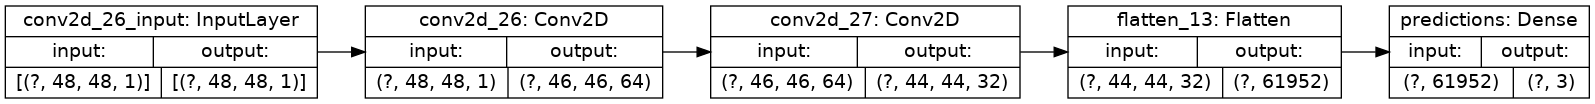

In [107]:
mod = define_model_singlechannel(image_height, image_width, N_bands, n_ntl_bins)
plot_model_architecture(mod, landscape="Horz")

In [104]:
history = evaluate_model(mod, trainX, trainY, testX, testY, CNN_MODEL_CHECKPOINT)


Epoch 00001: val_loss improved from inf to 1.09665, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00002: val_loss improved from 1.09665 to 1.09523, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00003: val_loss improved from 1.09523 to 1.02926, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00004: val_loss improved from 1.02926 to 1.01905, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00005: val_loss improved from 1.01905 to 0.99525, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00006: val_loss improved from 0.99525 to 0.97716, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00007: val_loss did not improve from 0.97716

Epoch 00008: val_loss improved from 0.97716 to 0.97040, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00009: val_loss improved from 0.97040 to 0.97036, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00010: va

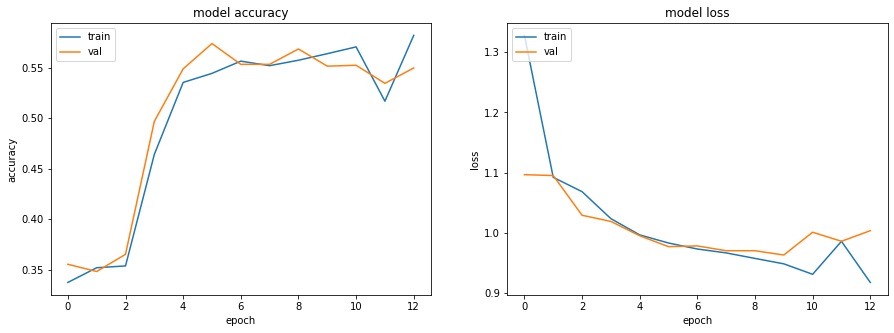

In [105]:
plot_model_accuracy_loss(history)

In [106]:
display_eval_metrics(mod, testX, testY, n_ntl_bins)

                  precision    recall  f1-score   support

Radiance Level 1       0.58      0.68      0.63       381
Radiance Level 2       0.56      0.64      0.60       384
Radiance Level 3       0.47      0.31      0.38       352

        accuracy                           0.55      1117
       macro avg       0.54      0.54      0.53      1117
    weighted avg       0.54      0.55      0.54      1117



## Run Model

In [78]:
model = define_model_imagenet(image_height, image_width, N_bands, n_ntl_bins)

In [79]:
evaluate_model(model, trainX, trainY, testX, testY, CNN_MODEL_CHECKPOINT)


Epoch 00001: val_loss improved from inf to 0.78763, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00002: val_loss improved from 0.78763 to 0.77376, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00003: val_loss did not improve from 0.77376

Epoch 00004: val_loss improved from 0.77376 to 0.76575, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00005: val_loss improved from 0.76575 to 0.75735, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00006: val_loss did not improve from 0.75735

Epoch 00007: val_loss did not improve from 0.75735

Epoch 00008: val_loss improved from 0.75735 to 0.75700, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00009: val_loss improved from 0.75700 to 0.75496, saving model to /home/ec2-user/SageMaker/script_CNN_2014.h5

Epoch 00010: val_loss did not improve from 0.75496

Epoch 00011: val_loss improved from 0.75496 to 0.75454, saving model to /home/ec2-user/SageMa

In [80]:
# DISPLAY IN-DEPTH EVALUTAION METRICS
best_model = load_model(CNN_MODEL_CHECKPOINT)
display_eval_metrics(model, testX, testY, n_ntl_bins)

                  precision    recall  f1-score   support

Radiance Level 1       0.80      0.72      0.76      3420
Radiance Level 2       0.63      0.70      0.66      3429
Radiance Level 3       0.65      0.63      0.64      3268

        accuracy                           0.68     10117
       macro avg       0.69      0.68      0.69     10117
    weighted avg       0.69      0.68      0.69     10117



## Save Best Model and Predicted Values to s3

In [81]:
## Save predicted values to s3
# TODO: I save file locally then send to s3; might be a way to send df directly to s3

# Predict Values
predY = best_model.predict(testX) # model.predict(testX)
predY = np.argmax(predY, axis = 1)
testY_bins = np.argmax(testY, axis = 1)

# Make Dataframe
results_df = pd.DataFrame({'predY': predY, 'testY': testY_bins})

# Save locally
results_df.to_csv(os.path.join(LOCAL_DIR, PREDICTION_FILENAME), index=False) 

# Send to s3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(CNN_DIR, PREDICTION_FILENAME)).upload_file(os.path.join(LOCAL_DIR, PREDICTION_FILENAME))

In [82]:
## Save best model to s3
boto3.Session().resource('s3').Bucket(bucket).Object(CNN_MODEL_S3_PATH).upload_file(CNN_MODEL_CHECKPOINT)